In [28]:
import subprocess, os, glob, itertools

input_path = './data/02_intermediate/kmer' #'./data/02_intermediate/fna_line'
output_path = './data/02_intermediate/kmer'
query_path = './query.fasta'
k = 10

filenames = glob.glob(os.path.join(input_path, '*.jf'))
#files = glob.glob(os.path.join(input_path, '*.jf'))

with open(query_path, 'w') as fd:
        for i in itertools.product('ATCG', repeat=int(k)):
            query = "".join(i)
            fd.write(f"{query}\n")

for filename in filenames:
    prefix = os.path.basename(filename).rsplit('.jf', 1)[0]
    base_name = prefix + '.jf'
    print('base_name', base_name)
    #command = f"jellyfish query {filename} < {query_path} > {os.path.join(output_path, prefix)}.txt"
    #print('command', command)
    #subprocess.run(command, shell=True)
            
    command = f"jellyfish dump -c -t {filename} > {os.path.join(output_path, prefix)}.txt"
    subprocess.run(command, shell=True)
    
    # Check if the file is empty
    with open(os.path.join(output_path, prefix)+'.txt', 'r') as file:
        content = file.read()
        if not content:
            print("The file is empty.")
        else:
            print("The file is not empty.")

    

    

base_name GCA_000021245.1.jf
The file is not empty.
The file is not empty.


In [39]:
def sort_kmer_counts(query_path, input_path, output_path):
    # Read the query.fasta file to get the correct order of k-mers
    with open(query_path, 'r') as query_file:
        query_order = [line.strip() for line in query_file]

    # Read the k-mer counts from the input file
    kmer_counts = {}
    with open(input_path, 'r') as input_file:
        for line in input_file:
            kmer, count = line.strip().split('\t')
            kmer_counts[kmer] = int(count)

    # Sort the k-mer counts based on the order in query.fasta
    sorted_kmer_counts = []
    for kmer in query_order:
        count = kmer_counts.get(kmer, 0)  # Use 0 if the k-mer is not in the input file
        sorted_kmer_counts.append((kmer, count))

    # Write the sorted k-mer counts to the output file
    with open(output_path, 'w') as output_file:
        for kmer, count in sorted_kmer_counts:
            output_file.write(f"{kmer}\t{count}\n")
    print('Success!')

# Usage
query_path = './query.fasta'
input_path = './data/02_intermediate/kmer/GCA_000021245.1.txt'
output_path = './data/02_intermediate/kmer/GCA_000021245.1.txt'
sort_kmer_counts(query_path, input_path, output_path)


Success!


path /mnt/A_16TB/ytsang/amr-genome
input file /mnt/A_16TB/ytsang/amr-genome/data/02_intermediate/kmer/GCA_000021245.1.tsv


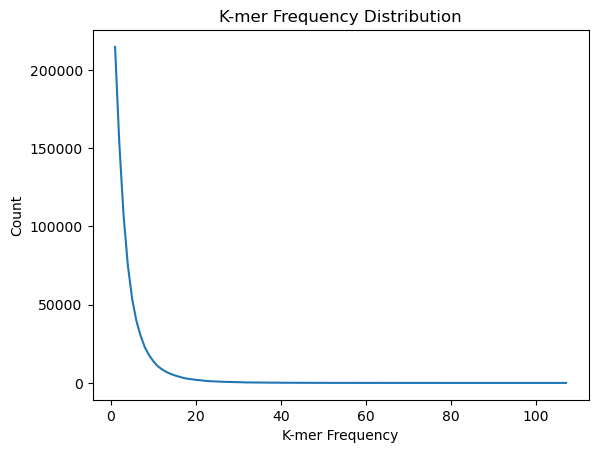

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import os

path = os.getcwd()
print('path', path)

# Read the k-mer frequency distribution file
input_file = os.path.join(path, 'data', '02_intermediate', 'kmer', 'GCA_000021245.1.tsv') 
print('input file', input_file)

# Ensure the file is read correctly
try:
    data = pd.read_csv(input_file, sep="\s+", header=None, engine='python')
except Exception as e:
    print(f"Error reading the file: {e}")
    exit()

# Convert columns to numpy arrays
x = data[0].to_numpy()
y = data[1].to_numpy()

# Plot the k-mer frequency distribution
plt.plot(x, y)
plt.xlabel('K-mer Frequency')
plt.ylabel('Count')
plt.title('K-mer Frequency Distribution')

# Save the plot as a PDF
output_file = "kmer_hist.pdf"
plt.savefig(output_file)

# Show the plot (optional)
plt.show()

In [3]:
import pandas as pd 
import os

def create_annotation(stratified_sample: pd.DataFrame, path_kmer: str) -> pd.DataFrame:
    # Read input data
    df = stratified_sample.copy()
    
    # Get a set of valid genome IDs (files that exist in path_kmer)
    valid_genomes = set()
    for filename in os.listdir(path_kmer):
        if filename.endswith('.txt'):
            genome_id = filename.rsplit('.', 1)[0]  # Remove both .txt from the end
            valid_genomes.add(genome_id)
                
    # Filter rows based on valid genomes
    df['genbank_id_match'] = df['genbank_id'].astype(str).apply(lambda x: '.'.join(x.split('.')[:2]))
    print(df['genbank_id_match'].head())
    df = df[df['genbank_id_match'].isin(valid_genomes)]
    df = df.drop('genbank_id_match', axis=1)
    
    # Transform resistant_phenotype
    def transform_phenotype(phenotype):
        if phenotype == 'intermediate' or phenotype == 'resistant':
            return 1  # Set as binary label 1 for intermediate and resistant
        return 0  # Set as binary label 0 for susceptible
    
    df['resistant_phenotype'] = df['resistant_phenotype'].apply(transform_phenotype)
    
    # Select required columns
    columns = ['genome_id', 'genbank_id', 'tax_id', 'antibiotic', 'resistant_phenotype', 
            'class', 'antibiotic_class', 'taxonomy_label', 'strain_identifiers']
    df = df[columns]
    
    return df

  
stratified_sample = pd.read_csv('./data/01_raw/stratified_sample.csv')
anno_output = './data/02_intermediate/annotation.csv'
path_kmer = './data/02_intermediate/kmer'

annotation = create_annotation(stratified_sample, path_kmer)
annotation.head()

0    GCA_000481765.1
1    GCA_003969195.1
2    GCA_000810205.1
3    GCA_003571525.1
4    GCF_001286025.1
Name: genbank_id_match, dtype: object


,genome_id,genbank_id,tax_id,antibiotic,resistant_phenotype,class,antibiotic_class,taxonomy_label,strain_identifiers
0,1.402497e+06,GCA_000481765.1,1402497,tobramycin,susceptible,aminoglycoside,aminoglycosides,pseudomonas,19660
1,2.877816e+02,GCA_003969195.1,287,tobramycin,susceptible,aminoglycoside,aminoglycosides,pseudomonas,strain MRSN1899
2,4.707020e+02,GCA_000810205.1,470,tobramycin,resistant,aminoglycoside,aminoglycosides,acinetobacter,ABUH514287
3,5.732006e+02,GCA_003571525.1,573,tobramycin,resistant,aminoglycoside,aminoglycosides,klebsiella,strain AR_0076
4,5.627761e+02,GCF_001286025.1,562,tobramycin,susceptible,aminoglycoside,aminoglycosides,escherichia,strain 402924


In [1]:
import pandas as pd 
merge_kmer_df = pd.read_parquet('./data/02_intermediate/merge_kmer_df.pq', engine='pyarrow')
merge_kmer_df.head()

,kmer,GCA_001874955.1,GCA_000417305.1,GCF_900092785.1,GCA_003345925.1,GCA_000516275.1,GCF_000822205.1,GCF_001701395.1,GCA_003345795.1,GCA_003571645.1,...,GCF_000822245.1,GCF_900093005.1,GCF_900093405.1,GCF_000821805.1,GCA_003074115.1,GCF_001286625.1,GCA_000808905.2,GCA_003571805.1,GCA_001664915.1,GCA_000417485.1
0,AAAAAAAAAA,0,0,0,1,1,1,1,1,0,...,0,0,0,0,0,1,2,0,1,0
1,AAAAAAAAAT,0,0,2,11,10,2,2,8,1,...,0,4,3,3,1,3,13,0,6,3
2,AAAAAAAAAC,2,2,1,2,1,1,1,2,0,...,0,0,2,2,2,3,6,2,1,2
3,AAAAAAAAAG,0,1,1,2,2,1,1,3,1,...,1,2,2,2,0,1,6,0,2,1
4,AAAAAAAATA,0,7,5,22,18,5,5,23,7,...,6,15,9,4,2,27,38,0,25,4
